In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
from filterpy.kalman import IMMEstimator
from filterpy.common import kinematic_kf
from target import TargetOnTrajectory, preprocess_trajectory_data
from target.common import constant_turn_rate_matrix, GenericTarget, DefinedTarget
from radar import Sensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def simulate(tracker, target, sensor, horizon, dim, order):
    target.reset()
    n_x = dim*(order+1)
    if type(tracker) == IMMEstimator:
        for filt in tracker.filters:
            filt.x = target.x
            filt.P = np.eye(n_x) * 1000
        mus = np.zeros((horizon, len(tracker.filters)))
    else:
        tracker.x = target.x
        tracker.P = np.eye(n_x) * 1000

    preds = np.zeros((horizon, 2))
    meas = np.zeros((horizon, 2))
    pos = np.zeros((horizon, 2))
    corr = np.zeros((horizon, 2))
    for t in range(horizon):
        tracker.predict()
        preds[t, :] = tracker.x[[0, order+1]].flatten()
        target.update()
        pos[t, :] = target.x.flatten()[[0, order+1]]
        z = sensor.measure(target.x)
        meas[t, :] = z.flatten()
        tracker.update(z)
        corr[t, :] = tracker.x[[0, order+1]].flatten()
        if type(tracker) == IMMEstimator:
            mus[t, :] = tracker.mu.flatten()
            
    data = dict(
        measurements=meas,
        positions=pos,
        predictions=preds,
        corrections=corr,
    )
    if type(tracker) == IMMEstimator:
        data['model_probs'] = mus
    return data

In [61]:
dt = 0.01
order=2
dim=2
f1 = np.array([
    [1, dt, dt**2/2],
    [0, 1, dt],
    [0, 0, 1]
])
f2 = np.copy(f1)
f2[2, 2] = 0
Z = np.zeros((3, 3))
Fcv = np.concatenate((np.concatenate((f1, Z), axis=0), np.concatenate((Z, f1), axis=0)), axis=1)
Fca = np.concatenate((np.concatenate((f2, Z), axis=0), np.concatenate((Z, f2), axis=0)), axis=1)
Fct1 = constant_turn_rate_matrix(0.4, dt)
Fct2 = constant_turn_rate_matrix(-0.4, dt)


q1 = np.diag([0.01, 0.0010, 0.0001])
Qcv = np.concatenate((np.concatenate((q1, Z), axis=0), np.concatenate((Z, q1), axis=0)), axis=1)


q2 = np.diag([0.1, 0.010, 0])
Qca = np.concatenate((np.concatenate((q2, Z), axis=0), np.concatenate((Z, q2), axis=0)), axis=1)

Qct = np.zeros((6, 6))

<IPython.core.display.Javascript object>


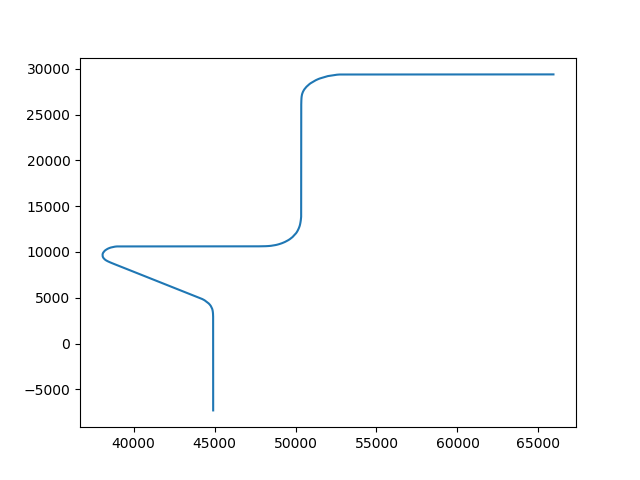

(18499, 2)

In [62]:
traj = pd.read_csv('trajectories/traj_6.csv').to_numpy()[:, :2]
plt.figure()
plt.plot(traj[:, 0], traj[:, 1], '-')
plt.show()
traj.shape

In [80]:
np.linalg.eig(R)

(array([4.07232401e-01, 2.21717286e+03]),
 array([[-0.90273491,  0.43019725],
        [-0.43019725, -0.90273491]]))

<IPython.core.display.Javascript object>


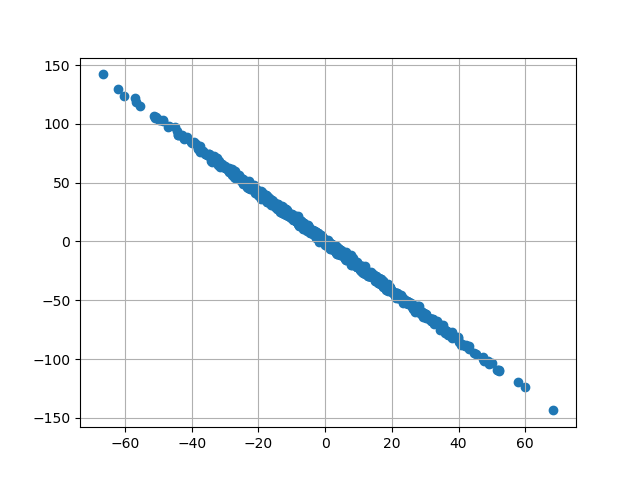

In [82]:
r = np.random.multivariate_normal(np.zeros((2,)), R, size=1000)
plt.figure()
plt.scatter(r[:, 0],r[:, 1] )
plt.grid()

In [84]:
np.sqrt(1/np.sqrt(100000))

0.056234132519034905

In [86]:
np.sqrt(50000**2 + 30000**2)

58309.518948453006

In [79]:
R = np.eye(2) * 50**2
R = np.array([
    [410.66333197, -860.88997752],
    [-860.88997752, 1806.91676187]
])
x0 = np.array([0, 300, 0, 0, 0, 0])

kf_cv = kinematic_kf(dim=dim, order=order, dt=dt)
kf_cv.Q = Qcv
kf_cv.F = Fca
kf_cv.R = R


kf_ca = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ca.Q = Qca
kf_ca.F = Fca
kf_ca.R = R

kf_ct1 = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ct1.Q = Qct
kf_ct1.F = Fct1
kf_ct1.R = R

kf_ct2 = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ct2.Q = Qct
kf_ct2.F = Fct2
kf_ct2.R = R

filters = [kf_cv, kf_ct1, kf_ct2]
n_filters = len(filters)
p_switch = 0.002
'''
probs = np.ones((n_filters,)*2)*p_switch/n_filters
np.fill_diagonal(probs, (1-p_switch,)*n_filters)
'''
probs = np.array([
    [1-p_switch, p_switch/2, p_switch/2],
    [p_switch, 1-p_switch, 0],
    [p_switch, 0, 1-p_switch]
])
mu = np.ones(probs.shape[0])/probs.shape[0]

imm = IMMEstimator(filters, mu, probs)
sensor = Sensor(kf_cv.H, R)
target = TargetOnTrajectory(preprocess_trajectory_data(traj, dim=2, order=2))
# target = GenericTarget(x0, F=constant_turn_rate_matrix(0.3, dt), Q=np.zeros((6,)*2))
# Fct_target = constant_turn_rate_matrix(0.25, dt)
# target = DefinedTarget(x0, st_models={0: Fcv, 500:Fct_target, 1000:Fcv, 1500:Fct2, 2000:Fcv}, p_noises={0: np.zeros((6, 6))})
horizon= traj.shape[0] - 1
# horizon=2500

In [74]:
trackers = dict(
    cv=kf_cv,
    ca=kf_ca,
    IMM=imm
)

results = dict()

for label, tracker in trackers.items():
    results[label] = simulate(tracker, target, sensor, horizon, dim, order)

<IPython.core.display.Javascript object>


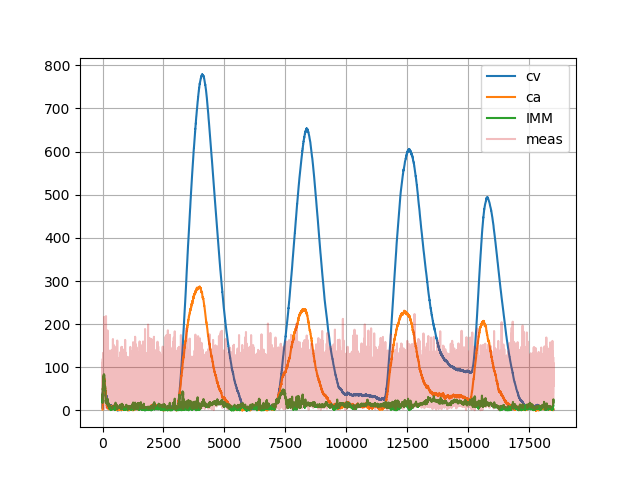

In [75]:
plt.figure()
for label, result in results.items():
    error = np.linalg.norm(result['positions'] - result['corrections'], axis=1)
    plt.plot(error, label=label)
plt.plot(np.linalg.norm(result['positions'] - result['measurements'], axis=1), alpha=0.3, label='meas')

plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


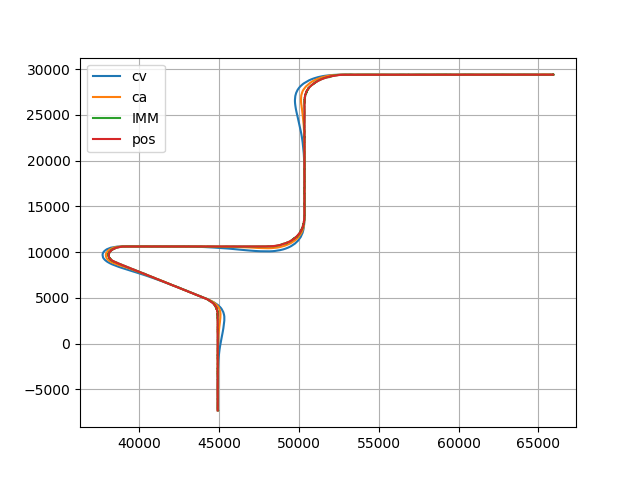

In [76]:
plt.figure()
for label, result in results.items():
    plt.plot(result['predictions'][:, 0], result['corrections'][:, 1], '-', label=label)
plt.plot(result['positions'][:, 0], result['positions'][:, 1], '-', label='pos')
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


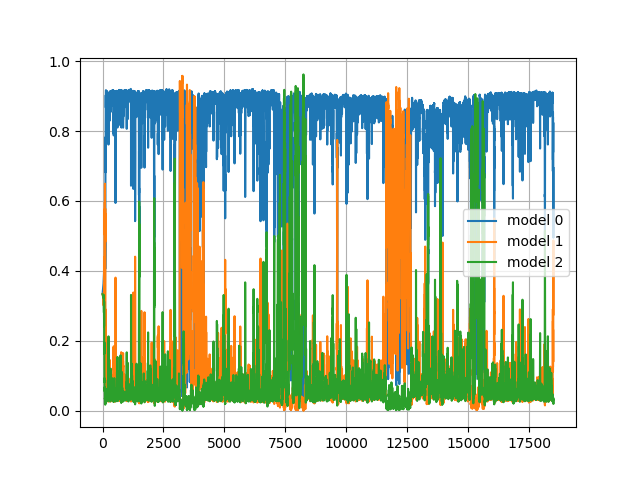

In [77]:
plt.figure()
for idx in range(results['IMM']['model_probs'].shape[1]):
    plt.plot(results['IMM']['model_probs'][:, idx], label='model {}'.format(idx))
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


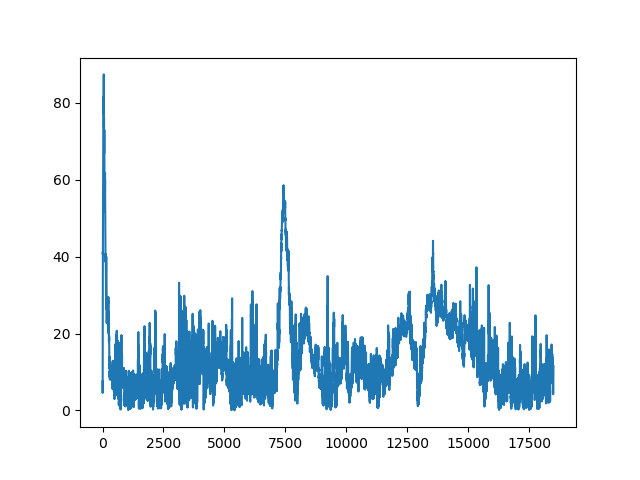

In [33]:
plt.figure()
result = results['IMM']
error = np.linalg.norm(result['positions'] - result['corrections'], axis=1)
plt.plot(error)